Just my Comments from the Reference Document to understand what was going on!

Importing Libraries

In [1]:
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

2. Loading Data

In [4]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S2"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = "./../../Data Extraction/Extracted Data/MT_S1_raw.csv"      # r"..\\..\\Data Extraction\\Extracted Data\\"+monkey+"_raw.csv"

df = pd.read_csv(datafile_path)

headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
print(headers)

# getting the activity matrix
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]

# velocity data
velocity_matrix = df[["x_velocity", "y_velocity"]]
# acceleration data
acceleration_matrix = df[["x_acceleration", "y_acceleration"]]

# transpose the data
activity_matrix_t = activity_matrix.transpose().to_numpy()
velocity_matrix_t = velocity_matrix.transpose().to_numpy()
acceleration_matrix_t = acceleration_matrix.transpose().to_numpy()

print(df["Timestamp"])

['Unnamed: 0', 'Timestamp', 'Neuron1', 'Neuron2', 'Neuron3', 'Neuron4', 'Neuron5', 'Neuron6', 'Neuron7', 'Neuron8', 'Neuron9', 'Neuron10', 'Neuron11', 'Neuron12', 'Neuron13', 'Neuron14', 'Neuron15', 'Neuron16', 'Neuron17', 'Neuron18', 'Neuron19', 'Neuron20', 'Neuron21', 'Neuron22', 'Neuron23', 'Neuron24', 'Neuron25', 'Neuron26', 'Neuron27', 'Neuron28', 'Neuron29', 'Neuron30', 'Neuron31', 'Neuron32', 'Neuron33', 'Neuron34', 'Neuron35', 'Neuron36', 'Neuron37', 'Neuron38', 'Neuron39', 'Neuron40', 'Neuron41', 'Neuron42', 'Neuron43', 'Neuron44', 'Neuron45', 'Neuron46', 'Neuron47', 'Neuron48', 'Neuron49', 'x_velocity', 'y_velocity', 'x_acceleration', 'y_acceleration']
0           1.000
1           1.001
2           1.002
3           1.003
4           1.004
           ...   
800996    801.996
800997    801.997
800998    801.998
800999    801.999
801000    802.000
Name: Timestamp, Length: 801001, dtype: float64


In [34]:
import sys
import os
from pathlib import Path
# Use the current working directory as the base path
base_path = Path(os.getcwd())
print("Current working directory:", base_path)

# Assuming the working directory is 'my_project/parent' and you want to import 'folder'
# The project root would be one level up:
project_root = base_path.parent
print(project_root)

# Now you can import the folder (as an implicit namespace package)
import utils

# For example, if folder contains some_module.py:
# folder.some_module.some_function()

from utils.LMU_Stack import LMUStack

Current working directory: /Users/arnimashrestha/BCI-Signal-Decoding/src/LMU - Basis
/Users/arnimashrestha/BCI-Signal-Decoding/src


In [35]:
from collections import deque

#synapses - act as filters or delays that are then applied to neural connections
#purpose of this class --> any signal passing through this synapse will be delayed by 200 ms
#ideal delay is a synapse that has been customed so that it delays the signal without filtering

class IdealDelay(nengo.synapses.Synapse):
    def __init__(self,delay):
        super().__init__()
        #stored delay value 
        self.delay= delay

    #sets up the delayed processing of the input signals
    def make_state(self,shape_in, shape_out, dt, dtype=None, y0=None):
        return{}
    
    #function makes a delated output function that stores past inputs
    def make_step(self, shape_in, shape_out, dt, rng, state):
        #deque = double-ended queue that allows insertion and removal of elements from BOTH ends (front and back)
        #delay buffer to store past inputs before they are output
        buffer= deque([0]*int(self.delay/dt)) 
    
        #processes the input x at time t 
        def delay_func(t,x):
            #appends at the end (the right)
            #stores newest input at the end of the queue

            buffer.append(x.copy())

            #appends at the front 
            #removes the oldest stored value from the front of the queue
            #returns the oldest value from deque (the first value)
            #FIFO (first in first out) - simulating delays
            return buffer.popleft()
        return delay_func


In [21]:
f= 2 #max frequency
rms= 0.30 #root mean square amplitutude of the signals
delay= 0.5
sim_t= 50 #total duration of the signal generation


#seed ensures reproductibiliy - same input will give the same output
with nengo.Network() as model:
    #nodes generate two independant white noise signals
    stim1= nengo.Node(output= nengo.processes.WhiteSignal(high=f, period= sim_t,rms= rms, y0=0, seed=0 ))
    stim2= nengo.Node(output= nengo.processes.WhiteSignal(high=f, period= sim_t, rms= rms, y0=0, seed=1))
    
    #node that merges both signals from stim 1 and stim 2
    #stim has multiple input dimension (size_in=2). This makes stim behave like a vector with two elements
    #expects two node inputs at every timestep
    stim= nengo.Node(size_in=2)


    nengo.Connection(stim1, stim[0]) #stim[0] is the first input channel
    nengo.Connection(stim2, stim[1]) #stim[1] is the second input channel

    p_stim= nengo.Probe(stim)
    #probing allows you to record and analyze signals inside a simulation 
    #if no probing occurs, then you won't be able to inspect what happens inside of a networ

    with nengo.Simulator(model, seed=0) as sim:
        sim.run(10)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


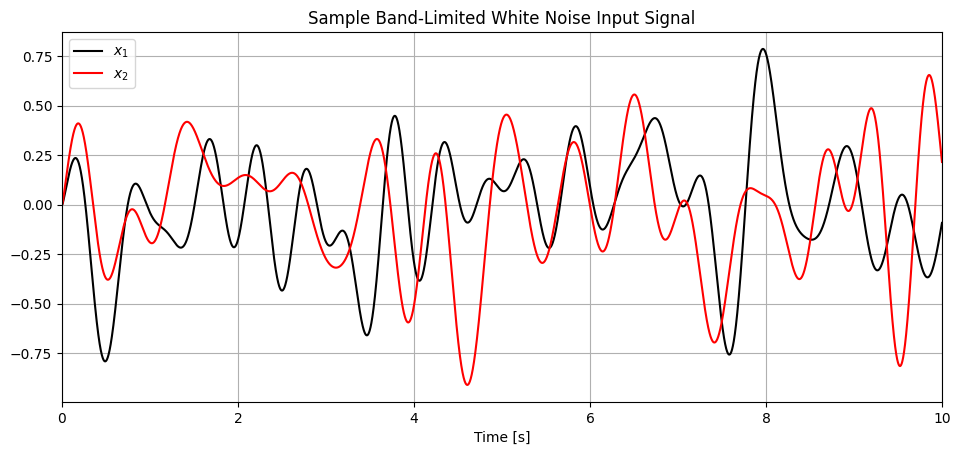

In [22]:
f, pl= plt.subplots(1,1)
f.subplots_adjust(right=1.5)

#syntax --> [;,0] -> indexing a 2D array or matrix
pl.plot(sim.trange(), sim.data[p_stim][:,0], 'k',label="$x_{1}$")
pl.plot(sim.trange(), sim.data[p_stim][:,1], 'r',label= "$x_{2}$" )
pl.set_title("Sample Band-Limited White Noise Input Signal")
pl.set_xlabel("Time [s]")
pl.set_xlim(0,10)
pl.legend()
pl.grid()

Build finished in 0:00:02.                                                      
Simulation finished in 0:00:12.                                                 


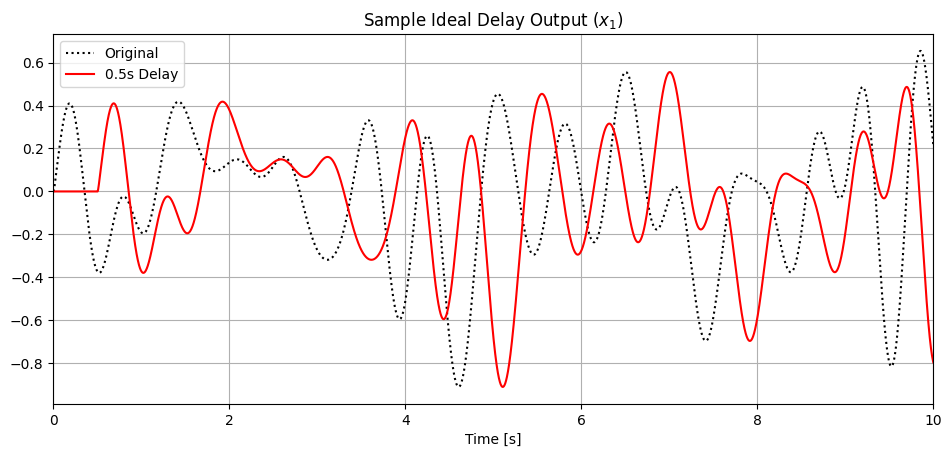

In [32]:
with model:
    err_node = nengo.Node(lambda t, x: x if t < sim_t * 0.8 else 0, size_in=2)

    # The synapse calculates the ideal delay transformation -- what we're trying to learn
    nengo.Connection(stim, err_node, synapse=IdealDelay(delay), transform=-1)

    p_err = nengo.Probe(err_node)

with nengo.Simulator(model, seed=0) as sim:
    sim.run(10)

f, pl = plt.subplots(1,1)
f.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_stim][:,1], 'k:', label="Original")
pl.plot(sim.trange(), -sim.data[p_err][:,1], 'r', label="0.5s Delay")
pl.set_title("Sample Ideal Delay Output ($x_{1}$)")
pl.set_xlabel("Time [s]")
pl.set_xlim(0,10)
pl.legend()
pl.grid()

In [27]:
with model:
    # The LMUs!
    lmu_set = LMUStack(2, order=8)
    
    # Note: we learn between Ensembles, and since we use Nodes as Passthroughs for the LMUStack, we need an intermediate Ensemble that holds the LMU's output
    intermediate = nengo.Ensemble(2*8*100, 2*8)

    # Our Estimated Time-Delayed Signal
    out = nengo.Ensemble(250, 2)

    # Connecting to input to the LMUs
    nengo.Connection(stim, lmu_set.input)

    # Connecting the LMUs to the intermediate ensemble
    nengo.Connection(lmu_set.output, intermediate)
    
    # Learning Connections (remember we hooked up the ground truth to err in the previous section)
    learn_conn = nengo.Connection(intermediate, out, function=lambda x: [0,0], learning_rule_type=nengo.PES(5e-4))
    nengo.Connection(out, err_node, synapse=0)
    nengo.Connection(err_node, learn_conn.learning_rule, synapse=None)

    # Some Probes for Visualization
    p_stim = nengo.Probe(stim)
    p_out = nengo.Probe(out, synapse=0.05)
    
with nengo.Simulator(model, seed=0) as sim:
    sim.run(sim_t)

Build finished in 0:00:02.                                                      
Simulation finished in 0:01:29.                                                 
